# 利用python对淘宝用户行为进行数据挖掘

## 1、环境搭建
### python
### pycharm
### anaconda和jupyter notebook

## 2、数据来源
数据来自于阿里云（阿里天池）数据分析项目：[来自淘宝的用户行为](https://tianchi.aliyun.com/dataset/dataDetail?dataId=649)

## 3、数据清洗和准备
从阿里天池下载下来的数据文件格式为csv  
表内包含的数据特征有： 

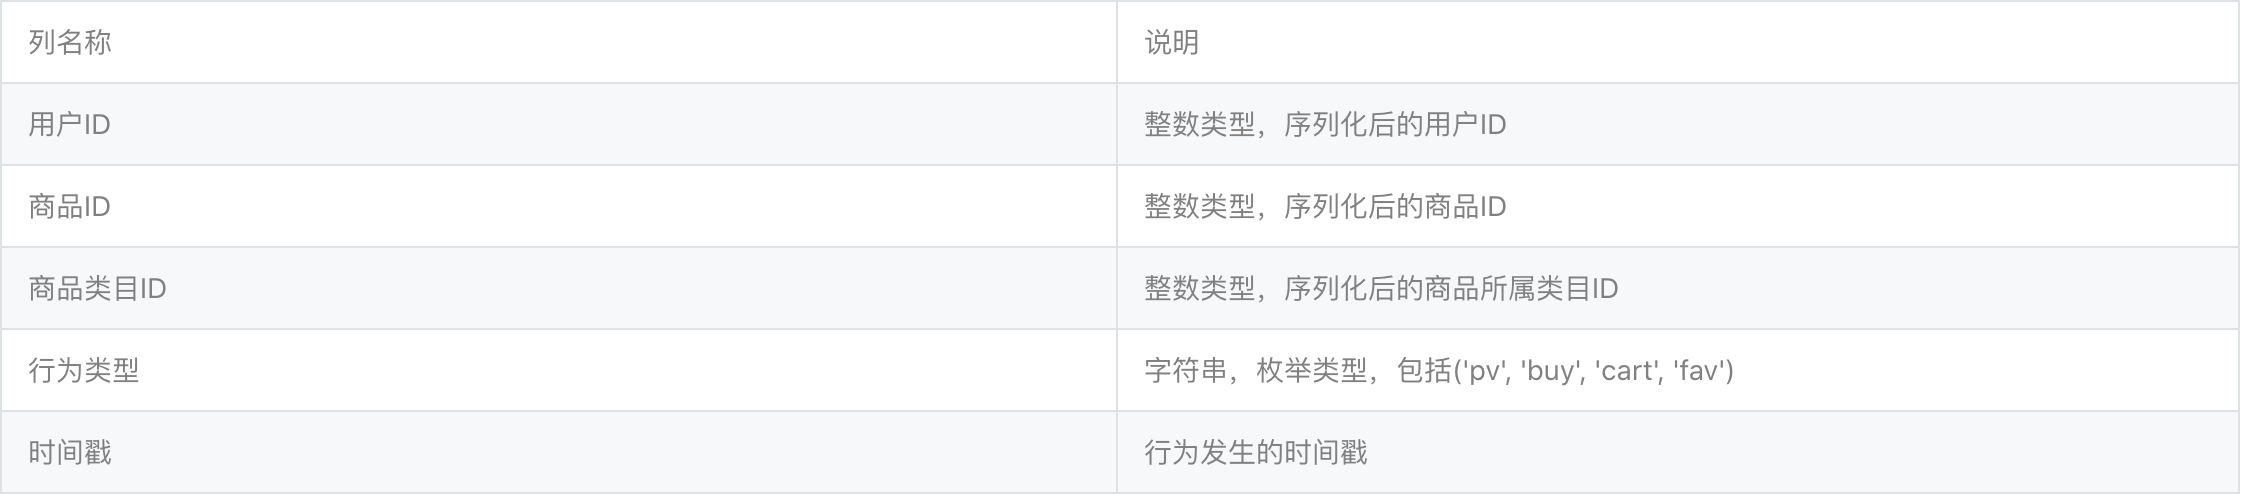 

淘宝用户行为特征四种字符串分别是：pv（点击）、buy（购买）、cart（加入购物车）、fav（收藏商品）  
需要进行的数据准备有：数据导入、缺失值处理、一致化处理、异常值处理

### 数据导入
python中导入csv数据格式的方法不止一种，可导入csv模块、numpy模块、pandas模块等。根据各种方式的差异以及此次数据分析会用到pandas，因此采取导入pandas的方式。  
```python
from pandas import read_csv
```

In [1]:
#导入一些必要的库

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
from pylab import mpl
from datetime import datetime

In [2]:
#导入下载的天猫用户行为数据

filename = 'UserBehavior.csv'
column_name = ['user_id', 'goods_id', 'type_id', 'behavior', 'timestamp']     #原数据中没有列名，因此设置列名
tb_dataset = pd.read_csv(filename, names = column_name)
print(tb_dataset.shape)
print(tb_dataset.dtypes)

(3835331, 5)
user_id        int64
goods_id       int64
type_id        int64
behavior      object
timestamp    float64
dtype: object


**导入后可知该数据集有3835331行，5列。**
### 数据清洗
**将时间数据转化为年月日格式、处理缺失值和异常值**  
**由于该数据集中，用户、商品、类型的id我们无法判断是否为异常值。同样也没用必要对他们进行重复值处理。因此我们判断行为类型和时间中是否有异常值。行为类型和时间戳的特殊性，将不属于四种行为以外的行为类型字符串和不在时间范围内的时间戳设为异常值即可**  
数据来源有说明时间范围是2017-11-25到2017-12-03


In [3]:
tb_dataset = tb_dataset[tb_dataset['behavior'].str.contains('pv|buy|cart|fav')]
tb_dataset = tb_dataset[tb_dataset['timestamp'] >= 1511539200]
tb_dataset = tb_dataset[tb_dataset['timestamp'] < 1512316800]
#去除异常时间戳和行为类型字符串所在的行

tb_dataset['datetime'] = tb_dataset['timestamp'].apply(lambda x: datetime.fromtimestamp(x))
tb_dataset['date'] = tb_dataset['datetime'].dt.date
tb_dataset['time'] = tb_dataset['datetime'].dt.time
#将时间戳改为时间格式、并将日期与时间分开，创建两个单独的列


tb_dataset.dropna()
#删除数据集中的空缺值，有一个值空缺整行删除

,user_id,goods_id,type_id,behavior,timestamp,datetime,date,time
0,1,2268318,2520377,pv,1.511544e+09,2017-11-25 01:21:10,2017-11-25,01:21:10
1,1,2333346,2520771,pv,1.511562e+09,2017-11-25 06:15:33,2017-11-25,06:15:33
2,1,2576651,149192,pv,1.511573e+09,2017-11-25 09:21:25,2017-11-25,09:21:25
3,1,3830808,4181361,pv,1.511593e+09,2017-11-25 15:04:53,2017-11-25,15:04:53
4,1,4365585,2520377,pv,1.511596e+09,2017-11-25 15:49:06,2017-11-25,15:49:06
...,...,...,...,...,...,...,...,...
3835325,255896,3844843,58498,pv,1.512111e+09,2017-12-01 14:50:00,2017-12-01,14:50:00
3835326,255896,5081283,4640311,pv,1.512111e+09,2017-12-01 14:50:13,2017-12-01,14:50:13
3835327,255896,2479617,2913673,pv,1.512111e+09,2017-12-01 14:50:24,2017-12-01,14:50:24
3835328,255896,2668495,58498,pv,1.512111e+09,2017-12-01 14:50:31,2017-12-01,14:50:31


## 4、数据挖掘与可视化
侧重发现：1、时段与用户行为间的关系。2、商品类别与用户行为间的关系
### 4.1 用户整体情况分析
点击量（浏览量）、用户数、人均点击量、跳失率、复购率，用户行为图(/天)、时段用户行为图

In [4]:
#访客量=点击量=pv数量，buy量，cart量，fav量
#用户数=不重复用户ID数量
#人均点击量=访客量/用户数
#跳失率=仅点击未进行其他行为数量/用户数

behavior_counts = tb_dataset['behavior'].value_counts()
print(behavior_counts)

pv      3431905
cart     213634
fav      111140
buy       76707
Name: behavior, dtype: int64


In [5]:
user_number = tb_dataset.user_id.nunique()  #计算淘宝不重复的用户ID，就是这段时间的用户数
pv_per_capita = behavior_counts['pv'] / user_number
print('2017-11-25到2017-12-03，访问量为：', behavior_counts[0], '用户数为：', user_number, '人均点击量为：', pv_per_capita)
print('以人次计，这段时间内的pv-buy转化率为{:3.2f}%，pv-cart转化率为{:3.2f}%，pv-fav转化率为{:3.2f}%'.format(behavior_counts.buy / behavior_counts.pv * 100, behavior_counts.cart / behavior_counts.pv * 100, behavior_counts.fav / behavior_counts.pv * 100))

2017-11-25到2017-12-03，访问量为： 3431905 用户数为： 37376 人均点击量为： 91.8210883989726
以人次计，这段时间内的pv-buy转化率为2.24%，pv-cart转化率为6.22%，pv-fav转化率为3.24%


**用户行为转化漏斗分析**
可见，按人次统计，从pv（点击）到购买的转化率只有2.24%，转化率非常低。  
一方面说明，淘宝购物网站对大多数人来说也有很大的商品信息浏览、比价等功能，而不仅仅是购买；  
另一方面，也说明这段时间有大量人次，在点击浏览行为后就流失了。导致这一原因的可能有：1、浏览后的购买行为引导设计不足。2、商品搜索推荐算法不足，导致用户搜索的商品并不能满足其要求。3、商品质量问题或者首页与实物差距过大。4、之后存在满减、促销等活动，用户为了等日期或者凑价格因此降低了近期的pv-buy转化率。这也和pv-cart转化率较高相符。  
另外，pv-cart转化率相比其他行为明显更高。这说明用户在浏览时，对于加入购物车行为更加喜欢（相比收藏）。可能与购物车相比收藏操作更加简便直观，支付更加方便、步骤更少有关；也可能是因为加入购物车的商品统一结算使得支付总额更加直观。  

建议：淘宝可以考虑优化商品推荐算法，加强对用户点击行为后的加入购物车行为与购买行为的引导，推出促进购买的相关活动，简化购买流程与步骤，考虑进一步开发优化购物车在比价、总价显示、下单、商品收藏等方面独特的优势。

In [6]:
#跳失率为按用户人数计算，仅仅浏览商品为进行其他任何行为的用户占总用户的比例
#由于pv行为用户未必进行其他行为，但其他行为用户一定不是跳失用户。因此先筛选pv行为以外三种行为用户数据，再利用用户ID去重，可以得到非跳失用户数量。
tb_not_only_pv_dataset = tb_dataset[tb_dataset['behavior'].str.contains('buy|chart|fav')]
not_only_pv = tb_not_only_pv_dataset.user_id.nunique()
miss_rate = (user_number - not_only_pv) / user_number
print('2017-11-25到2017-12-03，跳失率为：', miss_rate)

#复购率为按用户人数计算，在这段时间内，进行了两次以上购买行为的用户占总用户的比例
tb_buy_dataset = tb_dataset[tb_dataset['behavior'].str.contains('buy')]
only_buy_data = tb_buy_dataset.duplicated(subset = ['user_id'], keep = False)   #不重复的用户id则为False
only_buy = len(only_buy_data[only_buy_data == False])                #false个数就等于未复购人数
Repurchase_rate = (user_number - only_buy) / user_number
print('2017-11-25到2017-12-03，复购率为：', Repurchase_rate)

2017-11-25到2017-12-03，跳失率为： 0.20438249143835616
2017-11-25到2017-12-03，复购率为： 0.7675513698630136


可见，20%的用户在浏览之后没有进行其他行为而流失。  
77%左右的用户在这段时间内有两次以上的购买行为。  

### 4.1.1 用户行为频次图（日期）
先作出每一日的访客情况表，再作图

behavior     buy   cart    fav      pv
date                                  
2017-11-25  7535  21416  11519  354564
2017-11-26  7722  22513  12004  364554
2017-11-27  8538  21244  11087  341435
2017-11-28  8096  20626  11192  338412
2017-11-29  8468  21111  11413  349892
2017-11-30  8533  21588  11379  358866
2017-12-01  8049  24215  11854  373859
2017-12-02  9792  30771  15344  476867
2017-12-03  9974  30150  15348  473456
date
2017-11-25    26710
2017-11-26    27107
2017-11-27    26893
2017-11-28    26976
2017-11-29    27394
2017-11-30    27844
2017-12-01    28065
2017-12-02    36701
2017-12-03    36614
Name: user_id, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


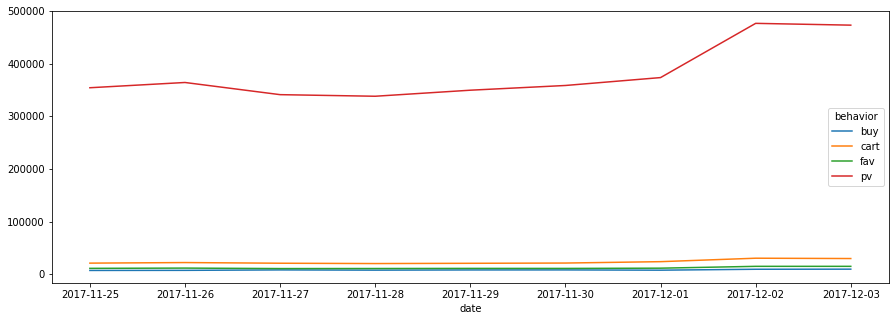

In [7]:
date_behavior_counts = tb_dataset.groupby('date').behavior.value_counts().unstack()   #按日期分类统计用户行为，每日的pv就是访客量
date_user_counts = tb_dataset.groupby('date').user_id.nunique()     #按日期统计user_id，并去重
print(date_behavior_counts)
print(date_user_counts)
print(date_behavior_counts.plot(figsize=(15, 5)))

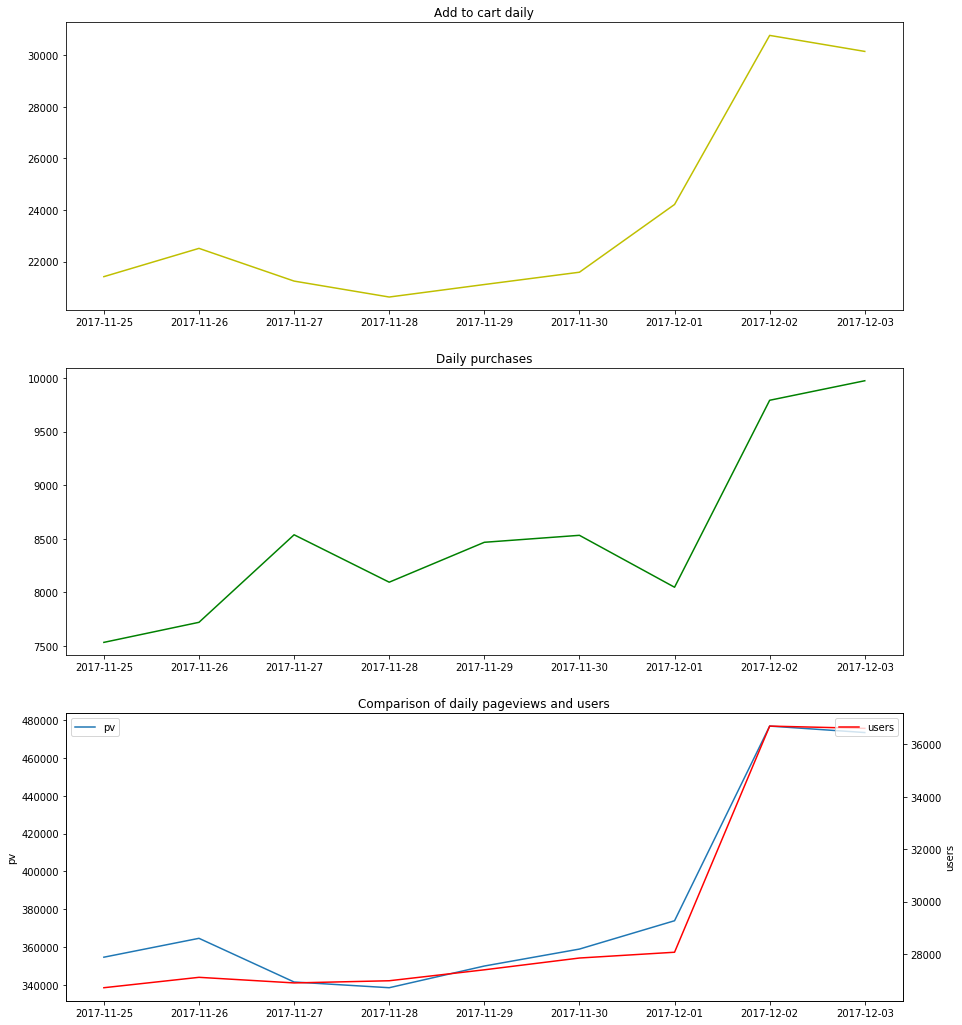

In [8]:
date_fig_x = date_behavior_counts.index      #准备x轴数据
date_fig_y1 = date_behavior_counts.pv.tolist()    #准备y1轴数据
date_fig_y2 = date_user_counts.values    #准备y2轴数据

date_fig = plt.figure(figsize = (15, 18))  

date_fig_ax1 = date_fig.add_subplot(313)    #设置画布与图像
date_fig_ax1.plot(date_fig_x, date_fig_y1)    #制图
date_fig_ax1.set_title("Comparison of daily pageviews and users")    #设置标题
date_fig_ax1.set_ylabel('pv')                    #y1轴标签
date_fig_ax1.legend(labels = ['pv'], loc = 'upper left')     #设置y1图例

date_fig_ax2 = date_fig_ax1.twinx()
date_fig_ax2.plot(date_fig_x, date_fig_y2, 'r')
date_fig_ax2.set_ylabel('users')
date_fig_ax2.legend(labels = ['users'], loc = 'upper right')


date_fig_ax3 = date_fig.add_subplot(312)
date_fig_ax3.plot(date_fig_x, date_behavior_counts.buy.tolist(), 'g')
date_fig_ax3.set_title("Daily purchases")

date_fig_ax4 = date_fig.add_subplot(311)
date_fig_ax4.plot(date_fig_x, date_behavior_counts.cart.tolist(), 'y')
date_fig_ax4.set_title('Add to cart daily')

plt.show()

对比2017-11-25到2017-12-03每日的用户行为与用户数趋势可以发现，两者趋势大致相同。    
1、这段时间内，对比访客量（点击率）和用户数量，11-25到12-01用户数增长比较平滑，访客量波动增长。  
2、在12月2日前后，两者到达顶峰。  
3、2017年12月2日和3日是周末，由此推测pv和uv（用户数）波动是周末或者促销活动导致。部分用户周末（促销活动）前先挑选商品，当日再下单购买的行为，也符合用户活跃度和用户数量的波动差异。并且11月25、26日也是周末，也呈现这样的趋势；但是最值与波动幅度没有2、3日明显。再结合购买曲线在12月1日的下滑。因此应该有周末和活动两方面的原因，使得用户周五加入购物车的人次上升，但购买人次下降。也可能是双十二提前的一波预热活动。  
4、对比购物车和购买折线图可以看出，尤其是加入购物车与pv这两条曲线的相似程度很高，两个行为的相关度很高。但是在用户数一定的情况下，购物车与购买两种行为的波动趋势呈负相关。推测用户数一定的情况下，用户购买行为频率越高，其将商品加入购物车的行为频率就会减少；也就是说用户的消费更加果断。反之亦然。另外，也可以看出，购买行为极值一般在购物车行为极值之后一天，存在一定的滞后。

### 4.1.2 用户行为频次图（时段）
根据一天中的24个时段，统计人次与人数变化。

In [9]:
#首先转化time列数据类型 => datetime，并作为数据库索引（这样去掉了日期信息）
tb_dataset.time = pd.to_datetime(tb_dataset.time, format = '%H:%M:%S')
tb_dataset.index = tb_dataset.time

In [10]:
time_behavior_counts = tb_dataset.resample('H').behavior.value_counts().unstack()    #和上面一样这里也可以用groupby(pd.Grouper())实现。但是resample更加简洁
time_user_counts = tb_dataset.resample('H').user_id.nunique()
print(time_behavior_counts)
print(time_user_counts)

behavior              buy   cart   fav      pv
time                                          
1900-01-01 00:00:00  2231   7059  3949  115985
1900-01-01 01:00:00   848   3251  1720   52597
1900-01-01 02:00:00   482   1729  1055   28850
1900-01-01 03:00:00   236   1310   706   20048
1900-01-01 04:00:00   272   1071   603   17523
1900-01-01 05:00:00   284   1517   740   21842
1900-01-01 06:00:00   680   3002  1735   45613
1900-01-01 07:00:00  1390   5658  2965   85347
1900-01-01 08:00:00  2465   7510  4109  118589
1900-01-01 09:00:00  3634   8975  4999  143905
1900-01-01 10:00:00  4903  10243  5753  167055
1900-01-01 11:00:00  4784  10157  5755  162163
1900-01-01 12:00:00  4497   9959  5596  163736
1900-01-01 13:00:00  4787  10646  5942  180039
1900-01-01 14:00:00  4529  10590  5563  175619
1900-01-01 15:00:00  4750  10915  5979  183936
1900-01-01 16:00:00  4455  10648  5599  176896
1900-01-01 17:00:00  3946  10042  5371  159449
1900-01-01 18:00:00  3613   9585  5048  165784
1900-01-01 19

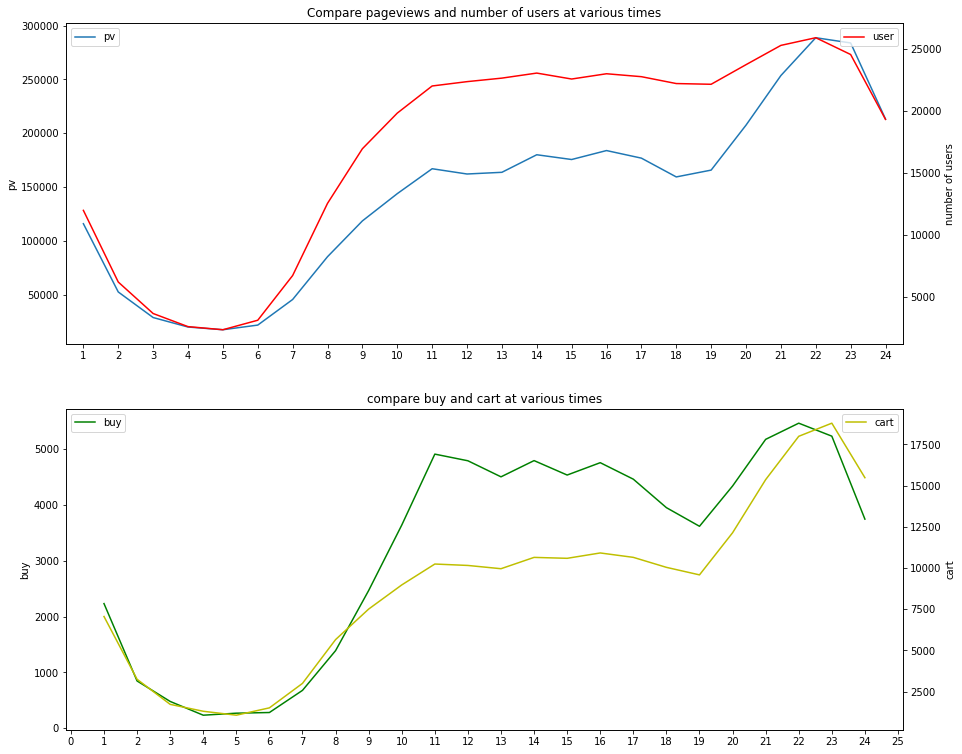

In [11]:
time_fig_x = list(range(1, 25))
time_fig_y1 = time_behavior_counts.pv.to_list()
time_fig_y2 = time_user_counts.values

time_fig = plt.figure(figsize = (15, 13))

time_fig_ax1 = time_fig.add_subplot(211)
time_fig_ax1.set_title('Compare pageviews and number of users at various times')
time_fig_ax1.plot(time_fig_x, time_fig_y1)
time_fig_ax1.set_ylabel('pv')
time_fig_ax1.legend(labels = ['pv'], loc = 'upper left')
time_fig_ax1.xaxis.set_major_locator(plt.MultipleLocator(1))     #设置x轴刻度（）默认情况下不是24个刻度
plt.xlim(0.5, 24.5)

time_fig_ax2 = time_fig_ax1.twinx()
time_fig_ax2.plot(time_fig_x, time_fig_y2, 'r')
time_fig_ax2.set_ylabel('number of users')
time_fig_ax2.legend(labels = ['user'], loc = 'upper right')

time_fig_ax3 = time_fig.add_subplot(212)
time_fig_ax3.plot(time_fig_x, time_behavior_counts.buy.tolist(), 'g')
time_fig_ax3.set_title('compare buy and cart at various times')
time_fig_ax3.set_ylabel('buy')
time_fig_ax3.legend(labels = ['buy'], loc = 'upper left')
time_fig_ax3.xaxis.set_major_locator(plt.MultipleLocator(1)) 

time_fig_ax4 = time_fig_ax3.twinx()
time_fig_ax4.plot(time_fig_x, time_behavior_counts.cart.tolist(), 'y')
time_fig_ax4.set_ylabel('cart')
time_fig_ax4.legend(labels = ['cart'], loc = 'upper right')

plt.show()

比对这段时间内，一天中不同时间段的用户行为与数量折线图。  
1、用户数与购买，访客量与加入购物车行为，依旧有较高的相关性。  
2、用户的购买行为极值主要发生在10点到16点，以及20点到23点。  
3、一天中访客量有两个增长点，分别是早上和晚上的7点，推测分别是因为起床和晚餐。购买行为高峰位于访客高峰之后。但与日期用户行为不同，购买行为高峰位于加入购物车高峰之前，且曲线更加陡峭。  
  由此可以推测，大多数用户的行为习惯是：在浏览之后，一些容易决定购买的商品大多会直接购买；而一些大件或短时无法购买的商品用户会选择放入购物车，等待未来的促销活动或者再做考虑；这就导致在日期上购物车高峰前置，时段上后置。  
4、综合访问数、用户数、购买曲线。可以发现，白天，尤其是10点到16点，这段时间相比其他时间段用户数增长比点击量增长更加明显，购买数量也有明显的增长。这说明，用户的浏览、购买更加高效，用更少的浏览量就决定了购买行为。但不排除工作日和周末的区别、以及部分商品是用户前一个晚上浏览加入购物车的。  
  因此，可以考虑加大20点以后对用户购买行为的引导力度，推出促销活动。推测用户在白天购物目的更明确、购买决定更果断。而晚上尽管用户数最高，但是用户更倾向浏览，有更大的成交量增长空间。也可以针对白天与夜晚用户行为倾向的不同，推出差异化的活动。

### 4.1.3 活跃用户

In [12]:
#示例，显示这段时间内用户行为次数前10的用户
tb_top10_pv = tb_dataset.user_id.value_counts().head(10)
print(tb_top10_pv)
#购买前十
tb_top10_buy = tb_dataset[tb_dataset['behavior'].str.contains('buy')].user_id.value_counts().head(10)
print(tb_top10_buy)

115477     781
142071     738
221012     730
116139     724
182888     716
164127     714
114912     689
190589     672
115906     668
1010419    665
Name: user_id, dtype: int64
234304     84
107932     72
122504     69
128379     65
242650     61
190873     61
1008380    57
165222     51
140047     47
1003983    43
Name: user_id, dtype: int64


举例。特意留意这些用户行为活跃、购买活跃的用户。并可以进一步细分为高活跃、高消费，高活跃、低消费，低活跃、高消费，低活跃、低消费用户群体，针对群体推出不同活动。或利用RFM模型，将用户活跃度与购买行为对比大样本赋分，找出有价值的用户。  
对于重要价值用户，他们是最优质的用户，需要重点关注并保持， 应该提高满意度，增加留存；

对于重要保持用户，他们最近有购买，但购买频率不高，可以通过活动等提高其购买频率；

对于重要发展用户，他们虽然最近没有购买，但以往购买频率高，可以做触达，以防止流失；

对于一般价值用户，他们最近没有购买，以往购买频率也不高，特别容易流失，所以应该赠送优惠券或推送活动信息，唤醒购买意愿。

## 4.2 商品整体情况分析
购买次数最多的商品、购买次数最多的商品类别、

In [13]:
tb_top10_goods = tb_dataset[tb_dataset['behavior'].str.contains('buy')].goods_id.value_counts().head(10)
print(tb_top10_goods)
tb_top10_type = tb_dataset[tb_dataset['behavior'].str.contains('buy')].type_id.value_counts().head(10)
print(tb_top10_type)

3122135    58
3031354    32
2964774    27
2560262    26
1910706    25
1116492    23
257772     23
1042152    23
3964583    22
3189426    22
Name: goods_id, dtype: int64
1464116    1432
2735466    1388
4145813    1297
2885642    1205
4756105    1097
4801426    1053
982926      923
2640118     698
3002561     686
4357323     630
Name: type_id, dtype: int64


举例。以上演示了这段时间内，销量前10的商品与商品类别。同样可统计分析其他商品行为。  
针对部分商品或类别，与日期、时段、用户行为等信息结合分析也大量的数据价值。

### 4.2.1商品相关性分析
 Apriori算法是一种挖掘关联规则的频繁项集算法。1、找到频繁集；2、在频繁集中通过可信度筛选获得关联规则。  
 FP-growth算法。1、构建FP树。2、从FP树中挖掘频繁项集。  
 FP-growth算法是一种用于发现数据集中频繁模式的有效方法。FP-growth算法利用Apriori原则，执行更快。Apriori算法产生候选项集，然后扫描数据集来检查它们是否频繁。由于只对数据集扫描两次，因此FP-growth算法执行更快。在FP-growth算法中，数据集存储在一个称为FP树的结构中。FP树构建完成后，可以通过查找元素项的条件基及构建条件FP树来发现频繁项集。该过程不断以更多元素作为条件重复进行，直到FP树只包含一个元素为止。

优点：一般要快于Apriori。
缺点：实现比较困难，在某些数据集上性能会下降。
适用数据类型：离散型数据。
 

```python
df = tb_dataset[tb_dataset['behavior'].str.contains('buy')]


def deal(data):
	return data.tolist()

df_goods_id = df.groupby('user_id').goods_id.apply(deal)
df_goods_arr = df_goods_id.values.tolist()

from mlxtend.preprocessing import TransactionEncoder	# 传入模型的数据需要满足特定的格式，可以用这种方法来转换为bool值，也可以用函数转换为0、1
 
te = TransactionEncoder()	# 定义模型
df_tf = te.fit_transform(df_goods_arr)
# df_01 = df_tf.astype('int')			# 将 True、False 转换为 0、1 # 官方给的其它方法
# df_name = te.inverse_transform(df_tf)		# 将编码值再次转化为原来的商品名
df_ok = pd.DataFrame(df_tf,columns=te.columns_)

#求频繁项集
from mlxtend.frequent_patterns import apriori	
frequent_items = apriori(df_ok, min_support=0.005, use_colnames=True, max_len=4).sort_values(by='support', ascending=False)	
frequent_items

#关联规则
from mlxtend.frequent_patterns import association_rules	
ass_rule = association_rules(frequent_items, metric='confidence', min_threshold=0.15)	
ass_rule.sort_values(by='leverage', ascending=False, inplace=True)  	
ass_rule
```

# 结论
1、2017-11-25到2017-12-03，访问量为： 3431905 用户数为： 37376 人均点击量为： 91.8210883989726  
以人次计，这段时间内的pv-buy转化率为2.24%，pv-cart转化率为6.22%，pv-fav转化率为3.24%  

2、用户行为转化转化率非常低。
一方面说明，淘宝购物网站对大多数人来说也有很大的商品信息浏览、比价等功能，而不仅仅是购买；
另一方面，也说明这段时间有大量人次，在点击浏览行为后就流失了。  
导致这一原因的可能有：1、浏览后的购买行为引导设计不足。2、商品搜索推荐算法不足，导致用户搜索的商品并不能满足其要求。3、商品质量问题或者首页与实物差距过大。4、之后存在满减、促销等活动，用户为了等日期或者凑价格因此降低了近期的pv-buy转化率。这也和pv-cart转化率较高相符。  
用户在浏览时，对于加入购物车行为更加喜欢（相比收藏）。  

建议：淘宝可以考虑优化商品推荐算法，加强对用户点击行为后的加入购物车行为与购买行为的引导，推出促进购买的相关活动，简化购买流程与步骤，考虑进一步开发优化购物车在比价、总价显示、下单、商品收藏等方面独特的优势。  

3、对比2017-11-25到2017-12-03每日的用户行为与用户数趋势可以发现，两者趋势大致相同。
    这段时间内，对比访客量（点击率）和用户数量，11-25到12-01用户数增长比较平滑，访客量波动增长。  
    在12月2日前后，两者到达顶峰。  
    2017年12月2日和3日是周末，由此推测pv和uv（用户数）波动是周末或者促销活动导致。  
    加入购物车与pv这两条曲线的相似程度很高，两个行为的相关度很高。但是在用户数一定的情况下，购物车与购买两种行为的波动趋势呈负相关。    

4、比对这段时间内，一天中不同时间段的用户行为与数量折线图。  
用户数与购买，访客量与加入购物车行为，依旧有较高的相关性。  
用户的购买行为极值主要发生在10点到16点，以及20点到23点。    
一天中访客量有两个增长点，分别是早上和晚上的7点，推测分别是因为起床和晚餐。  
综合访问数、用户数、购买曲线。可以发现，白天，尤其是10点到16点，这段时间相比其他时间段用户数增长比点击量增长更加明显，购买数量也有明显的增长。  

可以考虑加大20点以后对用户购买行为的引导力度，推出促销活动。推测用户在白天购物目的更明确、购买决定更果断。而晚上尽管用户数最高，但是用户更倾向浏览，有更大的成交量增长空间。也可以针对白天与夜晚用户行为倾向的不同，推出差异化的活动。   

5、关注活跃用户与热销商品，并针对不同类型的用户和商品差异化营销。


    